In [75]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.viewer import pv
from pygimli.physics.gravimetry import MagneticsModelling

In [76]:
dim = 2000
world = mt.createWorld(start=[-dim, -dim, -dim], end=[dim, dim, 0])
# pg.show(world)

In [77]:
fault = mt.createCube(size=[1000, 400, 100], marker=2)
fault.rotate([np.pi/2*0.8, 0, 0])
fault.translate([0, 0, -400])
geo = world + fault
pg.show(geo, style="wireframe", backend="trame")

Widget(value="<iframe src='http://localhost:58805/index.html?ui=P_0x1d851013eb0_18&reconnect=auto' style='widt…

(<pyvista.plotting.plotting.Plotter at 0x1d851013eb0>, None)

In [78]:
mesh = mt.createMesh(geo, quality=1.3)
print(mesh)

Mesh: Nodes: 440 Cells: 2137 Boundaries: 4427


In [79]:
mesh["mag"] = pg.solver.parseMapToCellArray([[1, 0], [2, 1]], mesh)
pl, _ = pg.show(mesh, style="wireframe", hold=True, backend="trame")
pv.drawMesh(pl, mesh, style="surface", filter={"threshold": dict(value=1, scalars="mag")})
pl.show()

Widget(value="<iframe src='http://localhost:58805/index.html?ui=P_0x1d851013be0_19&reconnect=auto' style='widt…

In [80]:
meshNED = pg.Mesh(mesh)
meshNED.swapCoordinates(0, 1)
meshNED.scale([1, 1, -1])
pl, _ = pg.show(meshNED, style="wireframe", hold=True, backend="trame")
pv.drawMesh(pl, meshNED, style="surface", filter={"threshold": dict(value=1, scalars="mag")})
pl.show()


Widget(value="<iframe src='http://localhost:58805/index.html?ui=P_0x1d850e620a0_20&reconnect=auto' style='widt…

In [81]:
x = np.arange(-1500, 1501, 50)
y = np.arange(-1500, 1501, 50)
X, Y = np.meshgrid(x, y)
print(X.shape, Y.shape)
pnts = np.column_stack([Y.flat, X.flat, np.ones_like(X.flat)])
print(pnts.shape)

(61, 61) (61, 61)
(3721, 3)


In [82]:
import pyIGRF
igrf = pyIGRF.igrf_value(lat=50.59465, lon=12.64139, alt=0)
print(np.transpose(igrf))

[1.82487977e+00 6.62570748e+01 1.96114146e+04 1.96014682e+04
 6.24521099e+02 4.45852635e+04 4.87078362e+04]


Wolfram alpha says T=49.5µT, X/Y/Z=19.6/1.56/45.4µT, so what's wrong?

In [83]:
pnts[:, 2] = 80
cmp = ["TF", "Bx", "By", "Bz"] # , "Bxx", "Bxy", "Bxz", "Byy", "Byz", "Bzz"]
fop = MagneticsModelling(meshNED, pnts, igrf=igrf, cmp=cmp)

(4427, 2)


   0%|          |0/3721 [00:00 < ?]

In [84]:
out = fop.response(mesh["mag"]*1e-4)
fields = np.reshape(out, [len(cmp), -1])

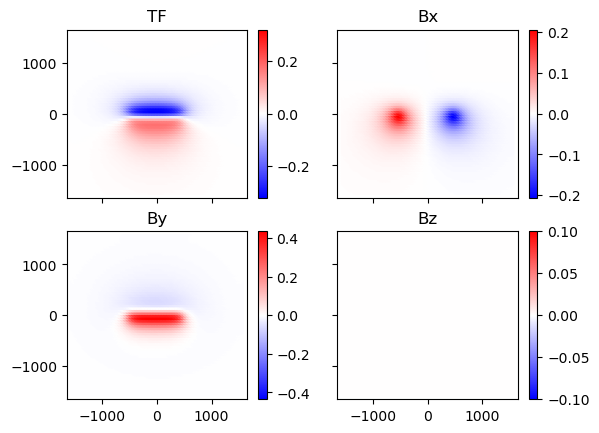

In [85]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
for i in range(4):
    fld = fields[i]
    vv = max(-min(fld), max(fld))
    sc = ax.flat[i].scatter(X.flat, Y.flat, c=fld, cmap="bwr", vmin=-vv, vmax=vv)
    ax.flat[i].set_title(cmp[i])
    fig.colorbar(sc, ax=ax.flat[i])
